## DNA curtain finder
----
[DNA_curtain_finder part_1](https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/5__DNA_curtain_finder_1.ipynb)

[DNA_curtain_finder part_2](https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/6__DNA_curtain_finder_2.ipynb)

[DNA_curtain_finder part_3](https://github.com/ReddingLab/Learning/blob/master/image-analysis-basics/7__DNA_curtain_finder_3.ipynb)


This notebook is part of a three part walk-through of the Al-Gore-rhythm we can use to find individual DNA strands in our images. This notebook starts us off by outlining our method to locate each DNA curtain within an image. 







In [1]:
#Dependencies
import smtools.alignment as al
from smtools.misc import skewnormal
from skimage.external.tifffile import imread
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from skimage.exposure import equalize_adapthist
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage.interpolation import rotate
from matplotlib.patches import Rectangle


import os
import numpy as np
import matplotlib.pyplot as plt


There are four test images supplied with this tutorial. I am going to begin by opening each of them. 

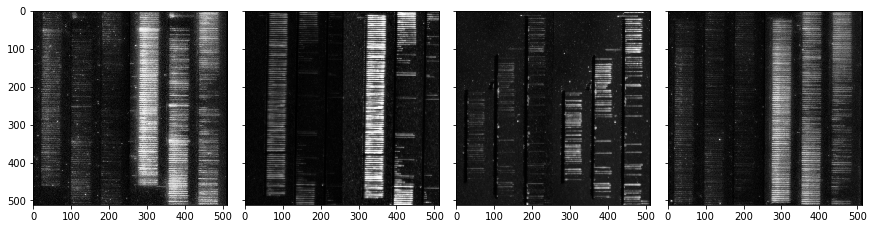

In [2]:
im_list = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list.append(equalize_adapthist(imread("test_images/"+i)))

fig, subplots = plt.subplots(1,4,figsize =(12,3),
                             constrained_layout=True, 
                             sharex = True, sharey = True)
for i,ax in zip(im_list,subplots.reshape(-1)):
    ax.imshow(i, cmap = "Greys_r")

plt.show()


Then I am going to use some imported functions to locate the major features in these images. To start, we are going to use [canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detector) from [scikit-image](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html) to mark the high confidence edges in the image. Then we are going draw lines on those edges using a [hough_line](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.probabilistic_hough_line) transform. There are a couple parameters that we are going to set for line transform, here are their meanings, which can also be found on their docs.

* line_length — Minimum accepted length of detected lines. We set this to be roughly the size of our DNA in pixels
* theta — Angles at which to compute the transform, in radians. We are setting this here to allow a set of angles in between ~ 84&deg;-96&deg; 
* line_gap — Maximum gap between pixels to still form a line. Increase the parameter to merge broken lines more aggressively

Importantly, this algorithm may yield different results each time it is run, though it should be relatively robust. The reason for the variability is the algorithm accesses pixels in a radom fashion when detecting lines, such that if lines share, pixels the first line to be detected removes the common pixels (and pixels in the area around it) from being accesed by other lines which results in gaps in the other lines. This is also why we do not use this method to find the individual DNA strands below.

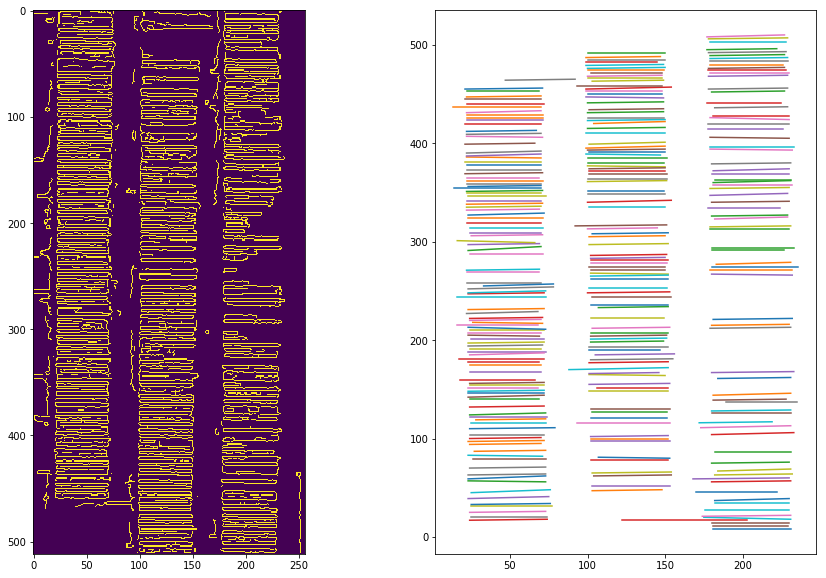

In [3]:
im = im_list[0]
ch1,ch2 = al.im_split(im)
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))

edges = canny(ch2)
lines = probabilistic_hough_line(edges,line_length = 45,
                                 theta = np.linspace(np.pi/2.-.1, np.pi/2.+.1, 500), 
                                 line_gap = 5)

ax1.imshow(edges)
for line in lines:
    ax2.plot((line[0][0], line[1][0]), (line[0][1], line[1][1]))
    

The method actually works pretty well, and we are going to get a couple things out of it. First, we can use these lines to orient our images. If our image is rotated a small amount (+/- x&deg; away from 90&deg; see above in definition of theta) we can look at all of the lines drawn by the transform, and calculate the most likely angle of rotation.

In [4]:
import warnings
warnings.filterwarnings('ignore')

def find_rotang(Image, line_length = 40,
                theta = None, line_gap = 5, tilt = .1):
    if theta is None:
        theta = np.linspace(np.pi/2.-tilt, np.pi/2.+tilt, 500)
        
    edges = canny(equalize_adapthist(Image))
    lines = probabilistic_hough_line(edges,line_length=line_length,
                                     theta=theta,line_gap=line_gap)
    
    rise = [line[1][1]-line[0][1] for line in lines]
    run = [line[1][0]-line[0][0] for line in lines]
    rotation = 180*np.tan(np.mean(rise)/np.mean(run))/np.pi
    return rotation

for i in im_list:
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    print(angle)

0.5101027668946406
0.46749019703965283
-0.19175900747050248
0.6312715229992211


Because the hough line transform is variable, its worth taking a quick look at how reproducible this measurement is. The take home is on a single pass, we ought not use this for much more than a general rotation measurement. However, we could make several calculations and average to do much better. That said, there are not any current reasons why we need to get "highly" accurate rotations of our images, but it is useful to get them close to straight for how we will identify individual DNA strands later on, which means a single pass should suffice.

mean rotation angle:   0.509 ,  standard deviation:  0.055
mean rotation angle:   0.555 ,  standard deviation:  0.104
mean rotation angle:   -0.201 ,  standard deviation:  0.065
mean rotation angle:   0.654 ,  standard deviation:  0.043


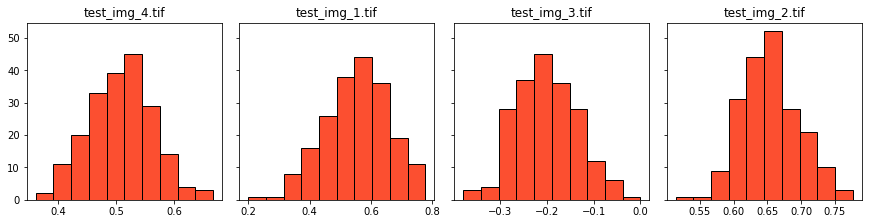

In [5]:
fig, subplots = plt.subplots(1,4,figsize =(12,3),
                             constrained_layout=True, 
                             sharey = True)
for i,ax,name in zip(im_list,subplots.reshape(-1), os.listdir("test_images/")):
    angles = []
    ch1,ch2 = al.im_split(i)
    for i in range(200):
        angles.append(find_rotang(ch2))
    ax.set_title(name)
    ax.hist(angles, ec = "k", fc = "#fc4f30")
    print("mean rotation angle:  ", f'{np.mean(angles):.3f}',",  standard deviation:  " f'{np.std(angles):.3f}')
plt.show()

The second, and more useful bit of information we get from the lines found by the hough transform is the general bounds of each curtain. We are going to use the average start and end positions of all of the lines to locate the left and right ends of the DNA, and also the top and bottom, of each curtain. 

To do this, I'm first going to plot all of the starting and ending positions of the lines. Then I'm going to use the [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) function from scipy.signal to locate where most lines begin and end. When I call this function, I also require that each peak is at least 50 pixels apart, this is because that's how long the DNA is in these images.

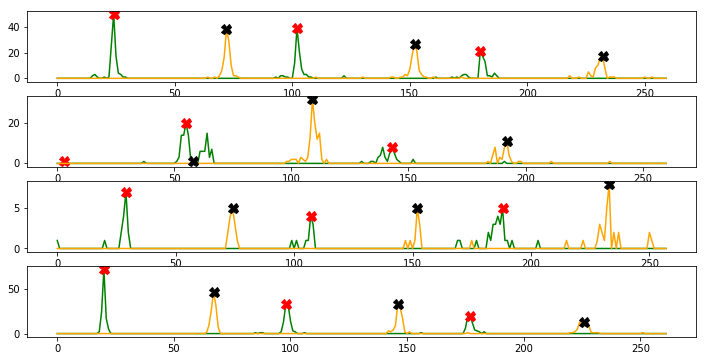

In [8]:
fig, subplots = plt.subplots(4,1,figsize =(12,6))

for i,ax in zip(im_list,subplots.reshape(-1)):
    
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)

    edges = canny(rotated_ch2)
    lines = probabilistic_hough_line(edges,line_length = 45,
                                     theta = np.linspace(np.pi/2.-.1, np.pi/2.+.1, 500), 
                                     line_gap = 5)
    
    line_starts,line_ends = [],[]
    for line in lines:
        line_starts.append(line[0][0])
        line_ends.append(line[1][0])
    x = np.linspace(0,rotated_ch2.shape[1]+1,rotated_ch2.shape[1]+1)
    starts,bins = np.histogram(line_starts,bins=x)
    ends,bins = np.histogram(line_ends,bins=x)

    peaks_start, _ = find_peaks(starts, distance = 50)
    peaks_end, _ = find_peaks(ends, distance = 50)

    ax.plot(starts, "green")
    ax.plot(peaks_start, starts[peaks_start],"rX", markersize = 10)

    ax.plot(ends, "orange")
    ax.plot(peaks_end, ends[peaks_end],"kX", markersize = 10)

plt.show()   
    
    
    
    
    

This does okay, but there's no safegaurds that we get the same number of starts and ends or that the peaks are "quality", you can prove this to yourself by running the above code several times. So we are going to do three things before our final assignment of the start and end position of each curtain. First, we are going to smooth the signal with the [savgol_filter](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html). Then we are going to throw out peaks below a defined threshold. Finally, we will require start and end positions to be a particular distance from one another.

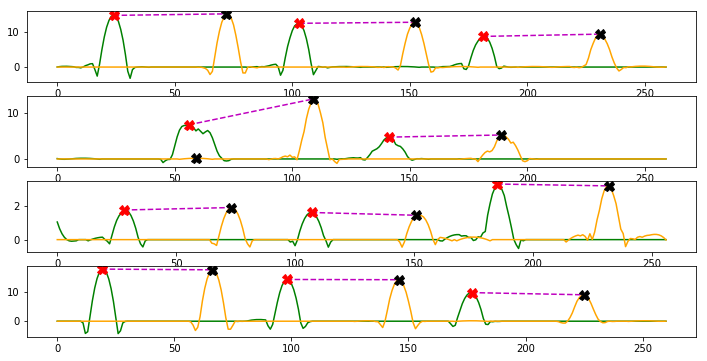

In [9]:
fig, subplots = plt.subplots(4,1,figsize =(12,6))

for i,ax in zip(im_list,subplots.reshape(-1)):
    
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)

    edges = canny(rotated_ch2)
    lines = probabilistic_hough_line(edges,line_length = 45,
                                     theta = np.linspace(np.pi/2.-.1, np.pi/2.+.1, 500), 
                                     line_gap = 5)
    line_starts = [line[0][0] for line in lines]
    line_ends = [line[1][0] for line in lines]
    x = np.linspace(0,rotated_ch2.shape[1]+1,rotated_ch2.shape[1]+1)
    starts,bins = np.histogram(line_starts,bins=x)
    ends,bins = np.histogram(line_ends,bins=x)

    smoothed_starts = savgol_filter(starts, 15, 3)
    smoothed_ends = savgol_filter(ends, 15, 3)

    peaks_start, _ = find_peaks(smoothed_starts, distance = 50)
    peaks_end, _ = find_peaks(smoothed_ends, distance = 50)
        
    curtains = []
    for j in peaks_start:
        for k in peaks_end:
            ##--- Here is the selection. Length has to be between 40 and 60 pixels
            ##--- and there has to be more than one end or begining of a line 
            ##--- on average per pixel at the peak maximum. We could do this within
            ##--- find_peaks with the width and rel_height settings, but i like it here
            ##--- because we dont have to set the peak width.
            if abs(j-k)>40 and abs(j-k)<60 and smoothed_starts[j]>1. and smoothed_ends[k]>1.:
                ax.plot([j,k],[smoothed_starts[j],smoothed_ends[k]], "m--")
                curtains.append((j,k))                        
            
    ax.plot(smoothed_starts, "green")
    ax.plot(peaks_start, smoothed_starts[peaks_start],"rX", markersize = 10)

    ax.plot(smoothed_ends, "orange")
    ax.plot(peaks_end, smoothed_ends[peaks_end],"kX", markersize = 10)

plt.show()   


Okay that gives us a good idea where each curtain starts and ends. Next we are going to go back through the lines detected by the hough transform, and assign each line to one of the curtains based on which curtain start position is closest to each line start position. Once all the lines are assigned to a curtain, then we find the position of the first and last line assigned to a particular curtain and add a few pixels to that position and call that the top or the bottom. 

In [10]:
data_list, masked_curtain_list = [], []
for i in im_list:
    
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    edges = canny(rotated_ch2)
    lines = probabilistic_hough_line(edges,line_length = 40,
                                     theta = np.linspace(np.pi/2.-.1, np.pi/2.+.1, 500), 
                                     line_gap = 5)
    line_starts = [line[0][0] for line in lines]
    line_ends = [line[1][0] for line in lines]
    x = np.linspace(0,rotated_ch2.shape[1]+1,rotated_ch2.shape[1]+1)
    starts,bins = np.histogram(line_starts,bins=x)
    ends,bins = np.histogram(line_ends,bins=x)
    smoothed_starts = savgol_filter(starts, 15, 3)
    smoothed_ends = savgol_filter(ends, 15, 3)
    peaks_start, _ = find_peaks(smoothed_starts, distance = 50)
    peaks_end, _ = find_peaks(smoothed_ends, distance = 50)
    curtains = []
    for j in peaks_start:
        for k in peaks_end:
            if abs(j-k)>40 and abs(j-k)<60 and smoothed_starts[j]>1. and smoothed_ends[k]>1.:
                curtains.append([j,k])
                
                
    d = {key[0]:[] for key in curtains}
    for line in lines:
        key = min(peaks_start, key=lambda x:abs(x-line[0][0]))
        if line[1][0]-line[0][0]<70:
            try:
                d[key].append(line[0][1])
            except KeyError:
                pass
    data = []
    curtain_mask = np.ones_like(rotated_ch2, dtype=bool)
    for m, n in zip(d, curtains):
        x_min = min(np.clip([n[0]-10], 0, rotated_ch2.shape[1]))
        x_max = max(np.clip([n[1]+10], 0, rotated_ch2.shape[1]))
        y_min = min(np.clip([x-5 for x in d[m]], 0, rotated_ch2.shape[0]))
        y_max = max(np.clip([x+5 for x in d[m]], 0, rotated_ch2.shape[0]))
        
        data.append((x_min, x_max, y_min, y_max))
        curtain_mask[y_min:y_max,x_min:x_max] = False

    data_list.append(data)
    rotated_ch2[curtain_mask] = 0
    masked_curtain_list.append(rotated_ch2)


Now lets get a sense of how this looks on the image.

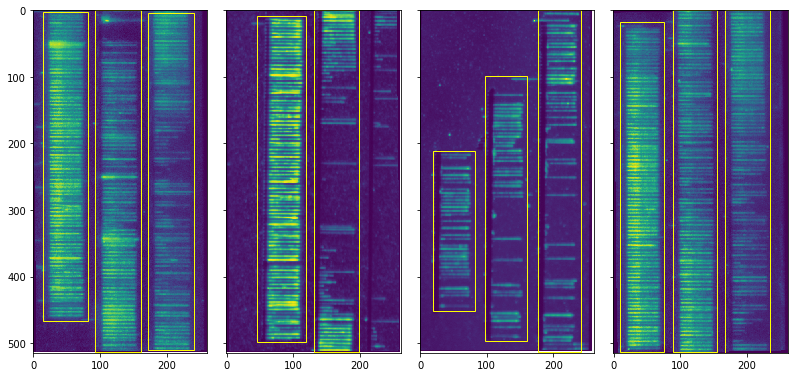

In [11]:
fig, subplots = plt.subplots(1,4,figsize =(11,5),
                             constrained_layout=True, 
                             sharex = True, sharey = True)
for i,j,ax in zip(im_list,data_list, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)

    ax.imshow(rotated_ch2)
    for k in j:
        ax.add_patch(Rectangle((k[0],k[2]),k[1]-k[0],k[3]-k[2],fill=False, color = "yellow"))
        
plt.show()

Okay, I really like this, and it looks like its doing a pretty smart job. So to wrap up this notebook, I am going to put all of this into a single definition.

In [12]:
def find_curtain(Image, distance = 50, line_length = 40, 
                   theta = None, line_gap = 5, tilt = .1, 
                   window = 15, order = 3, maxline = 70):

    if theta is None:
        theta = np.linspace(np.pi/2.-tilt, np.pi/2.+tilt, 500)
        
    edges = canny(equalize_adapthist(Image))
    lines = probabilistic_hough_line(edges,line_length=line_length,
                                     theta=theta,line_gap=line_gap)
    
    line_starts = [line[0][0] for line in lines]
    line_ends = [line[1][0] for line in lines]
    x = np.linspace(0,Image.shape[1]+1,Image.shape[1]+1)
    starts,bins = np.histogram(line_starts,bins=x)
    ends,bins = np.histogram(line_ends,bins=x)
    smoothed_starts = savgol_filter(starts, window, order)
    smoothed_ends = savgol_filter(ends, window, order)
    peaks_start, _ = find_peaks(smoothed_starts, distance = distance)
    peaks_end, _ = find_peaks(smoothed_ends, distance = distance)
    curtains = []
    for j in peaks_start:
        for k in peaks_end:
            if (abs(j-k)>line_length and abs(j-k)<line_length+20 
                and smoothed_starts[j]>1. and smoothed_ends[k]>1.):
                curtains.append((j,k))    
    d = {key[0]:[] for key in curtains}
    for line in lines:
        key = min(peaks_start, key=lambda x:abs(x-line[0][0]))
        if line[1][0]-line[0][0]<maxline:
            try:
                d[key].append(line[0][1])
            except KeyError:
                pass
    data = []
    curtain_mask = np.ones_like(Image, dtype=bool)
    for m, n in zip(d, curtains):
        x_min = min(np.clip([n[0]-10], 0, rotated_ch2.shape[1]))
        x_max = max(np.clip([n[1]+10], 0, rotated_ch2.shape[1]))
        y_min = min(np.clip([x-5 for x in d[m]], 0, rotated_ch2.shape[0]))
        y_max = max(np.clip([x+5 for x in d[m]], 0, rotated_ch2.shape[0]))
        
        data.append((x_min, x_max, y_min, y_max))
        curtain_mask[y_min:y_max,x_min:x_max] = False

    return data, curtain_mask

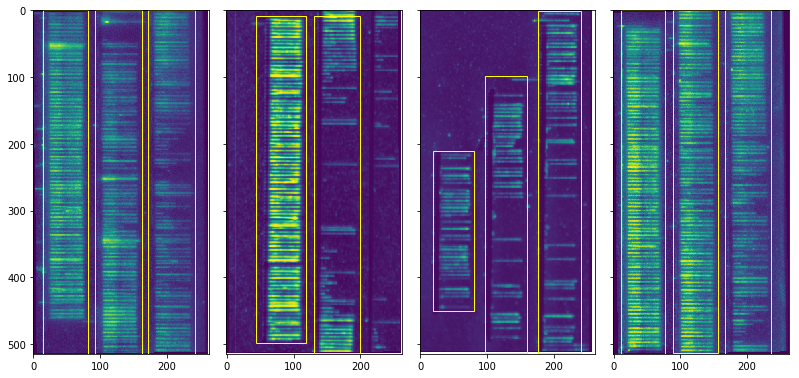

In [14]:
im_list_no_histogram_eq = []
for i in os.listdir("test_images/"):
    if i.endswith("tif"):
        im_list_no_histogram_eq.append(imread("test_images/"+i))


fig, subplots = plt.subplots(1,4,figsize =(11,5),
                             constrained_layout=True, 
                             sharex = True, sharey = True)
for i,ax in zip(im_list_no_histogram_eq, subplots.reshape(-1)):
    ch1,ch2 = al.im_split(i)
    angle = find_rotang(ch2)
    rotated_ch2 = rotate(ch2,angle)
    bounds, mask = find_curtain(rotated_ch2)

    ax.imshow(equalize_adapthist(rotated_ch2))
    for j in bounds:
        ax.add_patch(Rectangle((j[0],j[2]),j[1]-j[0],j[3]-j[2],fill=False, color = "yellow"))
plt.show()

The next job will be to locate each DNA within each one of these rectangles. For that, go to the `DNA_curtain_finder_2 notebook.`